In [17]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [18]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [19]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "big_gan")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.2.2+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [21]:
csv_path = os.path.join("..", "datasets", "semi_hard_mining_biggan_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 2150
val dataset size: 538


In [22]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "big" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [23]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 2150
validset size: 538


In [24]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [25]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 68
#batches in validloader : 17


In [26]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [27]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [28]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [29]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [30]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [31]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [32]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.80it/s]


successful weights saving...
epochs: 1, train_loss: 0.23822624280172236, valid_loss: 0.13832818497629726


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


successful weights saving...
epochs: 2, train_loss: 0.08840111873167403, valid_loss: 0.0935175515273038


model validating...: 100%|██████████| 17/17 [00:09<00:00,  1.76it/s]


epochs: 3, train_loss: 0.06849930276546408, valid_loss: 0.11015649753458359


model validating...: 100%|██████████| 17/17 [00:10<00:00,  1.69it/s]


successful weights saving...
epochs: 4, train_loss: 0.0508477703175124, valid_loss: 0.047003205208217394


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


successful weights saving...
epochs: 5, train_loss: 0.033700328922885305, valid_loss: 0.041062184992958516


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


successful weights saving...
epochs: 6, train_loss: 0.011913102120161057, valid_loss: 0.02349099955138038


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


epochs: 7, train_loss: 0.0074254708255038545, valid_loss: 0.06252425207811244


model validating...: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


epochs: 8, train_loss: 0.013475368347238092, valid_loss: 0.07253725059768733


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


epochs: 9, train_loss: 0.012473091921385597, valid_loss: 0.046719040940789616


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]


epochs: 10, train_loss: 0.00455064803142758, valid_loss: 0.07097218492451836


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


epochs: 11, train_loss: 0.002696370377260096, valid_loss: 0.04466524457230287


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


epochs: 12, train_loss: 0.0005946098005070406, valid_loss: 0.044672844164511734


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


epochs: 13, train_loss: 0.025599682155777428, valid_loss: 0.0870343293337261


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


epochs: 14, train_loss: 0.04370073152377325, valid_loss: 0.05344848510097055


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


epochs: 15, train_loss: 0.015949124908622575, valid_loss: 0.07075810870703529


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]


epochs: 16, train_loss: 0.01582848751807914, valid_loss: 0.034458935260772705


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


epochs: 17, train_loss: 0.031702494796584636, valid_loss: 0.11868320241132203


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


epochs: 18, train_loss: 0.14613071040195577, valid_loss: 0.10224803098860909


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


epochs: 19, train_loss: 0.04299162404940409, valid_loss: 0.06679476841407664


model validating...: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


epochs: 20, train_loss: 0.008949402610168737, valid_loss: 0.03661217189886991


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.24it/s]


epochs: 21, train_loss: 0.036486981546177584, valid_loss: 0.039481901508920336


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


epochs: 22, train_loss: 0.09379906711332939, valid_loss: 0.056609368499587566


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


epochs: 23, train_loss: 0.021328318535405046, valid_loss: 0.07711079760509379


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]


epochs: 24, train_loss: 0.00662827497238622, valid_loss: 0.04250021804781521


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


epochs: 25, train_loss: 0.007869903984315255, valid_loss: 0.029098572099910062


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


epochs: 26, train_loss: 0.0015876326052581564, valid_loss: 0.049450216924442965


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


epochs: 27, train_loss: 0.0017374434015330147, valid_loss: 0.03198846955509747


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


epochs: 28, train_loss: 0.0002953403574578902, valid_loss: 0.03759784558240105


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]


epochs: 29, train_loss: 0.0035431825501077317, valid_loss: 0.0350495936239467


model validating...: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]

epochs: 30, train_loss: 0.0013796187498990226, valid_loss: 0.04213564886766322


<function matplotlib.pyplot.show(close=None, block=None)>

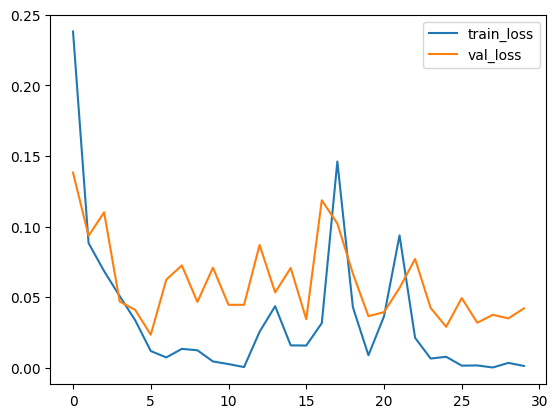

In [33]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [34]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "big" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [35]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 2688/2688 [00:35<00:00, 75.59it/s]


In [36]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img068940.jpg,-0.307798,-0.508969,0.926195,0.490313,-0.118310,0.543902,-0.299149,0.074082,-0.357804,...,0.713038,0.191845,-0.056985,0.112550,-0.610529,0.458800,0.197625,-0.475235,0.078249,-0.610605
1,big/biggan-data/854/img008397.jpg,0.003333,0.102581,0.077881,-0.084205,-0.661067,0.211122,-0.200058,-0.370851,-0.201713,...,0.198750,0.092547,-0.088540,0.090101,-0.325066,-0.235187,0.116681,0.083902,-0.021767,-0.593111
2,big/biggan-data/430/img003691.jpg,0.076727,0.022923,0.108149,-0.023014,-0.563118,0.242393,-0.241181,-0.315605,-0.188148,...,0.326242,0.122648,-0.080003,0.130744,-0.432383,-0.197485,0.221017,0.012781,-0.018262,-0.623360
3,big/biggan-data/202/img001166.jpg,0.077418,-0.008830,0.159454,0.008534,-0.493143,0.206487,-0.139443,-0.194636,-0.136551,...,0.340707,0.103308,-0.107604,0.083041,-0.417312,-0.076395,0.127017,-0.127815,-0.014595,-0.598420
4,coco/coco2017/train2017/img120939.jpg,-0.219276,-0.505708,0.831623,0.614833,-0.227905,0.512088,-0.223164,0.091130,-0.357716,...,0.726127,0.109013,-0.210231,0.091286,-0.752610,0.402502,0.172243,-0.546917,0.147707,-0.587038


In [37]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    dist = np.sqrt(dist)
    return dist

In [38]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList_biggan.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0      coco/coco2017/train2017/img134907.jpg
1       coco/coco2017/test2017/img026665.jpg
2       coco/coco2017/test2017/img014662.jpg
3      coco/coco2017/train2017/img115748.jpg
4       coco/coco2017/test2017/img038368.jpg
                       ...                  
532    coco/coco2017/train2017/img104789.jpg
533    coco/coco2017/train2017/img135260.jpg
534     coco/coco2017/test2017/img026185.jpg
535     coco/coco2017/test2017/img033140.jpg
536    coco/coco2017/train2017/img096916.jpg
Name: real, Length: 537, dtype: object
1074


,real,fake
0,coco/coco2017/train2017/img134907.jpg,big/biggan-data/608/img005662.jpg
1,coco/coco2017/test2017/img026665.jpg,big/biggan-data/768/img007430.jpg
2,coco/coco2017/test2017/img014662.jpg,big/biggan-data/929/img009225.jpg
3,coco/coco2017/train2017/img115748.jpg,big/biggan-data/193/img001053.jpg
4,coco/coco2017/test2017/img038368.jpg,big/biggan-data/81/img007900.jpg


In [39]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [40]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [45]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "big_gan")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(537, 2)

In [46]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path
    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)
    
    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if str(closestLabel).startswith("big"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 537it [00:24, 21.58it/s]


In [47]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
537
['real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', '

In [48]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "big" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 537it [00:26, 20.46it/s]


In [49]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1074
['real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 

In [52]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 537)
print(y_true.shape)

temp = np.array(["real"] * 537)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(537,)
(537,)
(1074,)
[[287 250]
 [259 278]]


In [53]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 52.61, 'Precision': 52.65, 'Recall': 51.77, 'Specificity': 53.4451, 'F1 Score': 52.2063}


In [54]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)